# Supervised Experiment

In [1]:
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.adversarial_autoencoder.supervised import SupervisedAdversarialAutoencoder

### Paper Config

In [8]:
NUM_EPOCHS = 10

INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM = 8
NUM_CLASSES = 10
PRIOR_STD = 5.0
recon_loss = nn.MSELoss()
init_recon_lr = 0.01
init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Load Training Data

In [9]:
# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten the image
])

# Load full MNIST training and test sets
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transform)

# DataLoaders with batch_size set to 100 as defined in your parameters
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get the actual transformed data (0-1 scaled, flattened)
X_train = torch.stack([x for x, _ in train_dataset])  # Exactly what DataLoader will see
X_test = torch.stack([x for x, _ in test_dataset])

Y_train = train_dataset.targets.clone()
Y_test = test_dataset.targets.clone()


### Model setup

In [10]:
aae = SupervisedAdversarialAutoencoder(
    input_dim=INPUT_DIM,
    ae_hidden=AE_HIDDEN,
    dc_hidden=DC_HIDDEN,
    latent_dim=LATENT_DIM,
    recon_loss_fn=recon_loss,
    num_classes=NUM_CLASSES,
    init_recon_lr=init_recon_lr,
    init_gen_lr=init_gen_lr,
    init_disc_lr=init_disc_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

### Train Model

In [11]:
# aae.load_weights("supervised_aae_weights5")
aae.train_mbgd(
    data_loader=train_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
)
aae.save_weights("supervised_aae_weights" + str(NUM_EPOCHS))

Training Epochs: 100%|██████████| 10/10 [02:18<00:00, 13.90s/epoch]

Weights saved to supervised_aae_weights10_*.pth


### Visualize

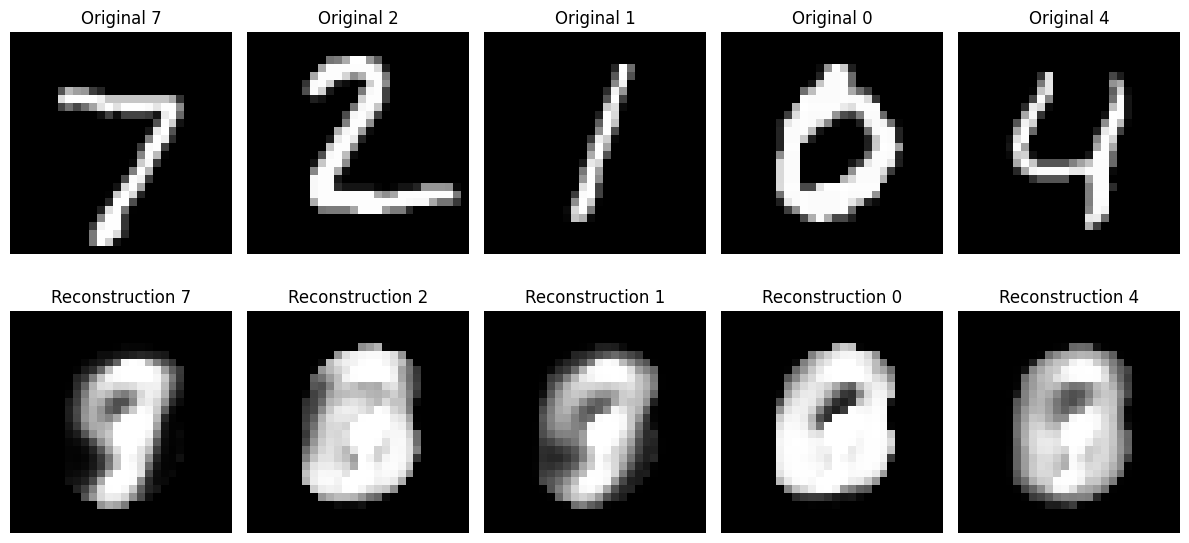

In [12]:
import matplotlib.pyplot as plt

def display_reconstructions(model, test_loader, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images = images.to(model.device)
    images_flattened = images.view(images.size(0), -1)
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=model.num_classes).float().to(model.device)
    
    # Pass through the encoder and decoder
    with torch.no_grad():
        z = model.encoder(images_flattened)
        z_cat = torch.cat([z, labels_one_hot], dim=1)
        recon_images = model.decoder(z_cat)
    
    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(2, num_images, figsize=(12, 6))
    
    for i in range(num_images):
        # Original image
        ax = axes[0, i]
        ax.imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Original {labels[i].item()}")
        
        # Reconstructed image
        ax = axes[1, i]
        ax.imshow(recon_images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Reconstruction {labels[i].item()}")
    
    plt.tight_layout()
    plt.show()

# Call the function to display the results
display_reconstructions(aae, test_loader)


In [14]:
# Generate and display samples
generated_samples = aae.generate_sample_from_test(train_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (784x1 and 784x1000)

In [8]:
# from sklearn.manifold import TSNE
# z_all = []
# y_all = []
# for x_batch, y_batch in train_loader:
#     z = aae.encoder(x_batch.to(device)).detach().cpu()
#     z_all.append(z)
#     y_all.append(y_batch)
# tsne = TSNE(n_components=2).fit_transform(torch.cat(z_all))


KeyboardInterrupt: 

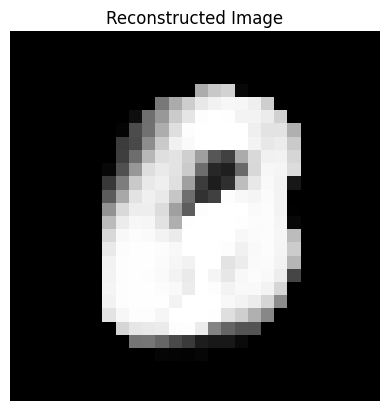

Pixel-wise difference: 63.45209503173828


In [15]:
model = aae
# Set model to evaluation mode
model.eval()

# Pick one image from the test set (or validation set)
x, labels = next(iter(train_loader))  # Or load a specific batch

x = x.to(model.device)  # Move the image to the device
y_onehot = torch.nn.functional.one_hot(labels, num_classes=model.num_classes).float().to(model.device)

# Flatten the image (if needed)
x_flat = x.view(x.size(0), -1)

# Forward pass to get reconstruction
with torch.no_grad():  # No need to track gradients
    z = model.encoder(x_flat)  # Encoder output (latent space)
    z_cat = torch.cat([z, y_onehot], dim=1)  # Concatenate latent vector with one-hot labels
    x_hat = model.decoder(z_cat)  # Reconstructed image

# Visualize the first image in the batch
output_img = x_hat[1].detach().cpu().view(1, 28, 28)  # Detach, move to CPU, reshape to 28x28
plt.imshow(output_img.squeeze(), cmap="gray")  # Squeeze to remove unnecessary dimensions
plt.title(f"Reconstructed Image")
plt.axis('off')
plt.show()
diff = torch.abs(x_hat[1] - x_hat[7])
print(f"Pixel-wise difference: {diff.sum()}")
